In [ ]:
!wget "https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731" -O image.jpeg

--2025-03-18 20:27:07--  https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731
Resolving service.archief.nl (service.archief.nl)... 195.169.53.74, 2001:610:1e0::2:adf:ff4a
Connecting to service.archief.nl (service.archief.nl)|195.169.53.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg              [     <=>            ]   1.16M  1021KB/s    in 1.2s    

2025-03-18 20:27:09 (1021 KB/s) - ‘image.jpeg’ saved [1219191]



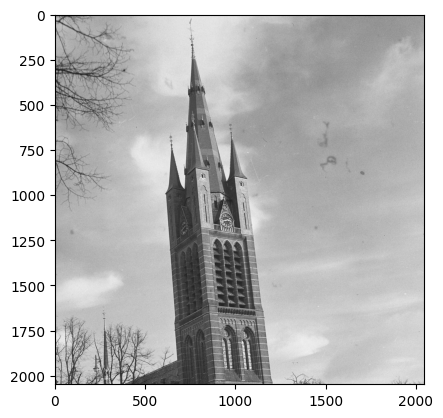

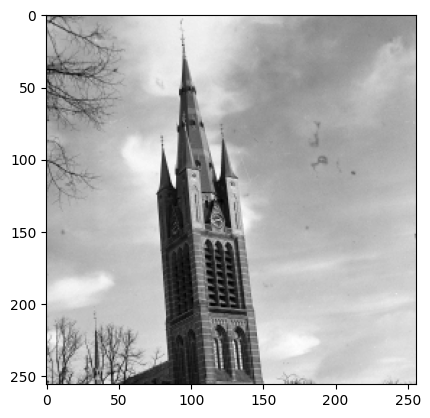

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image and convert to grayscale
img = cv2.imread('image.jpeg', cv2.IMREAD_GRAYSCALE)

# Define cropping coordinates
x, y, w, h = 700, 220, 2048, 2048
img = img[y:y+h, x:x+w]

# Show cropped image
plt.imshow(img, cmap='gray')
plt.show()

# Resize image to 256x256
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

# Show resized image
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
img.shape

(256, 256)

In [ ]:
import numpy as np
import cv2

def convolve_image(image: np.ndarray, kernel: np.ndarray):
    """
    Applies a convolution operation to a grayscale image using the specified kernel with 'same' padding.

    Parameters:
    - image (np.ndarray): Input image (grayscale).
    - kernel (np.ndarray): Convolution kernel.

    Returns:
    - np.ndarray: Convolved grayscale image.
    """
    if image.ndim != 2:
        raise ValueError("Input image must be a grayscale image (2D array).")

    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    pad_h = (kernel_height - 1) // 2
    pad_w = (kernel_width - 1) // 2

    # Pad image with zeros
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    # Initialize output array
    output = np.zeros((image_height, image_width), dtype=np.float32)

    # Perform convolution
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = np.sum(region * kernel)

    return output.astype(image.dtype)


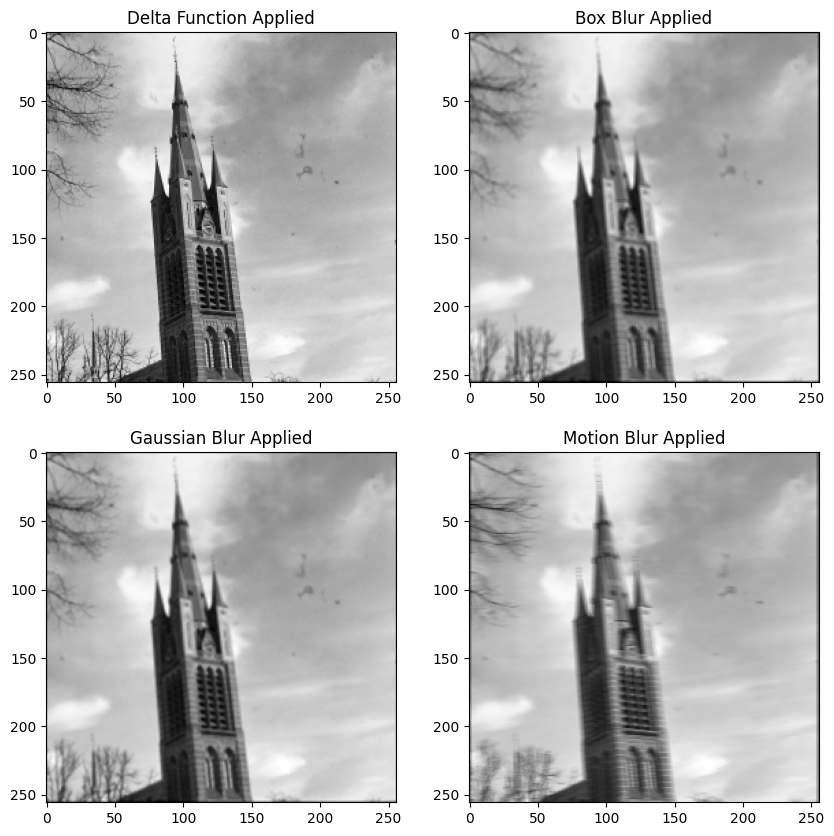

In [ ]:
### Delta function kernel (1x1 identity kernel)
delta_kernel = np.array([[1]], dtype=np.float32)
output_delta = convolve_image(img, delta_kernel)



### Box Blur
# box_blur_kernel = np.ones((3, 3), dtype=np.float32) / 9
box_blur_kernel = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
], dtype=np.float32)

box_blur_kernel /= box_blur_kernel.sum()  # Normalize
output_box_blur = convolve_image(img, box_blur_kernel)



### Gaussian Blur Kernel (3x3, sigma=1)
gaussian_blur_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=np.float32)

# # Gaussian Blur Kernel (3x3, sigma=2)
# gaussian_blur_kernel = np.array([
#     [np.exp(-((1**2 + 1**2) / 8)), np.exp(-((0**2 + 1**2) / 8)), np.exp(-((1**2 + 1**2) / 8))],
#     [np.exp(-((1**2 + 0**2) / 8)), np.exp(-((0**2 + 0**2) / 8)), np.exp(-((1**2 + 0**2) / 8))],
#     [np.exp(-((1**2 + 1**2) / 8)), np.exp(-((0**2 + 1**2) / 8)), np.exp(-((1**2 + 1**2) / 8))]
# ]) / (8 * np.pi)


gaussian_blur_kernel /= gaussian_blur_kernel.sum()  # Normalize
output_gaussian_blur = convolve_image(img, gaussian_blur_kernel)



### Motion Blur Kernel (1x5)
# motion_blur_kernel = np.ones((1, 5), dtype=np.float32)
motion_blur_kernel = np.array([
    [1, 1, 1, 1, 1]
], dtype=np.float32)

motion_blur_kernel /= motion_blur_kernel.sum()
output_motion_blur = convolve_image(img, motion_blur_kernel)



plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(output_delta, cmap='gray'), plt.title("Delta Function Applied")
plt.subplot(222), plt.imshow(output_box_blur, cmap='gray'), plt.title("Box Blur Applied")
plt.subplot(223), plt.imshow(output_gaussian_blur, cmap='gray'), plt.title("Gaussian Blur Applied")
plt.subplot(224), plt.imshow(output_motion_blur, cmap='gray'), plt.title("Motion Blur Applied")
plt.show()

In [8]:
import numpy as np
from scipy.signal import convolve2d

# Define input arrays
x = np.array([[1, 2, 3, 4, 5],
              [6, 7, 8, 9, 10]])

k = np.array([[1, 2, 3],
              [3, 2, 1]])

# Convolution in spatial domain
y_spatial = convolve2d(x, k, mode='full')

# Determine the required FFT size
fft_shape = (x.shape[0] + k.shape[0] - 1, x.shape[1] + k.shape[1] - 1)

print("FFT shape: ", fft_shape)

# Compute FFT of both arrays (padded to the correct size)
x_fft = np.fft.fft2(x, fft_shape)
k_fft = np.fft.fft2(k, fft_shape)

print(f"FFT of x({len(x_fft)}terms)")
print(f"FFT of k({len(k_fft)}terms)")
for term in k_fft:
    print(term)
    print()

for term in x_fft:
    print(term)
# print(f"FFT of k({len(k_fft)}terms}): ", k_fft)

# Multiply in frequency domain and inverse transform
y_freq = np.fft.ifft2(x_fft * k_fft).real

# Extract the same-sized output as spatial convolution
start_x = (y_freq.shape[0] - x.shape[0]) // 2
start_y = (y_freq.shape[1] - x.shape[1]) // 2
y_freq = y_freq[start_x:start_x + x.shape[0], start_y:start_y + x.shape[1]]

# Compute MSE
mse = np.mean((y_spatial - y_freq) ** 2)

# Compute PSNR
max_val = np.max(y_spatial)
psnr = 10 * np.log10(max_val**2 / mse)

# Print results
print("Convolution in spatial domain:\n", y_spatial)
print("\nConvolution in frequency domain:\n", y_freq)
print("\nMSE:", mse)
print("PSNR:", psnr)


FFT shape:  (3, 7)
FFT of x(3terms)
FFT of k(3terms)
[12.        +0.j          5.60387547-7.02703758j -0.49395921-2.16417669j
  2.89008374+1.39179097j  2.89008374-1.39179097j -0.49395921+2.16417669j
  5.60387547+7.02703758j]

[ 3.        -5.19615242j -2.63129672-6.70443471j -4.28781344-1.32261528j
  0.08333288-0.0568154j   0.23217839-3.09820533j -1.66207277-1.54217816j
  1.76567166-0.26613218j]

[ 3.        +5.19615242j  1.76567166+0.26613218j -1.66207277+1.54217816j
  0.23217839+3.09820533j  0.08333288+0.0568154j  -4.28781344+1.32261528j
 -2.63129672+6.70443471j]

[ 55.         +0.j         -15.06345036-16.8929229j
  12.5443685  -5.56529304j  -0.48091814 +6.64504848j
  -0.48091814 -6.64504848j  12.5443685  +5.56529304j
 -15.06345036+16.8929229j ]
[ -5.        -34.64101615j -13.38057518 +9.75540541j
  -4.65823221 -7.22670528j   2.46994333 -0.03605805j
  -4.79149539 -0.74897422j   2.50424294 -8.50189006j
   8.85611651 +5.0261714j ]
[ -5.        +34.64101615j   8.85611651 -5.0261714j
   

ValueError: operands could not be broadcast together with shapes (3,7) (2,5) 

In [ ]:
x = img

sigma = 2
k = np.array([
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**1) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
]) / (2 * np.pi * sigma**2)

k /= k.sum()

y1 = convolve2d(x, k, mode='full')
y2 = convolve2d(x, k, mode='same')
y3 = convolve2d(x, k, mode='valid')

print(y1.shape)
print(y2.shape)
print(y3.shape)

(258, 258)
(256, 256)
(254, 254)


In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def deconvolve_image(img, sigma_t=2):
    # Define input x and kernel k
    x = img
    sigma = 2
    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**1) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
    ]) / (2 * np.pi * sigma**2)

    k /= k.sum()

    # Convolution with 'full' mode
    y = convolve2d(x, k, mode='full')

    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**1) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 0**2) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**2) / (2 * sigma_t**2)) )]
    ]) / (2 * np.pi * sigma_t**2)

    k /= k.sum()

    # FFT size (use y's shape to ensure proper padding)
    fft_shape = y.shape

    # Compute FFTs
    y_fft = np.fft.fft2(y, fft_shape)
    k_fft = np.fft.fft2(k, fft_shape)

    # Unregularized deconvolution
    x_recovered = np.fft.ifft2(y_fft / k_fft).real

    # Regularized deconvolution
    # eps = 1e-8
    # x_recovered_fft = (y_fft * np.conj(k_fft)) / (np.abs(k_fft) ** 2 + eps)
    # x_recovered = np.fft.ifft2(x_recovered_fft).real


    # Extract the **valid** region (top-left alignment)
    valid_shape = x.shape
    x_recovered = x_recovered[:valid_shape[0], :valid_shape[1]]

    # Compute MSE, PSNR
    mse_recovery = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr_recovery = 10 * np.log10(max_val**2 / mse_recovery)

    # Print results
    print("Original x:\n", x)
    print("\nRecovered x from frequency domain:\n", np.round(x_recovered))
    print("\nMSE between original and recovered x:", mse_recovery)
    print("PSNR between original and recovered x:", psnr_recovery)

    # Plot images
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
    plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
    plt.subplot(133), plt.imshow(np.round(x_recovered), cmap='gray'), plt.title("Recovered Image")
    plt.show()

    return x_recovered, mse_recovery, psnr_recovery


sigmas = [1.98, 1.99, 2.00, 2.01, 2.03, 2.08, 2.20]
results = []

for sigma in sigmas:
    X_recovered, mse, psnr = deconvolve_image(img, sigma_t=sigma)
    results.append((X_recovered, mse, psnr))


for i, (X_recovered, mse, psnr) in enumerate(results):
    print(f"Results for sigma={sigmas[i]}:")
    print("Recovered x from frequency domain:", np.round(X_recovered))
    print("MSE between original and recovered x:", mse)
    print("PSNR between original and recovered x:", psnr)
    print("-------")

# plot all the recovered images and sigma values

plt.figure(figsize=(35, 5))
for i, (X_recovered, mse, psnr) in enumerate(results):
    plt.subplot(1, len(results), i + 1)  # Create subplots in a single row
    plt.imshow(X_recovered, cmap='gray')
    plt.title(f"Recovered Image (sigma={sigmas[i]})")

plt.show()  # Show all subplots together


Output hidden; open in https://colab.research.google.com to view.